## **Forward Pass Summary**

In [1]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt

In [2]:
nnfs.init() # Load the data

In [3]:
# Forward Pass

class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward pass
    def forward(self, inputs):
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

In [4]:
# Activation Functions

class Activation_ReLU:

    # Forward pass
    def forward(self, inputs):
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

class Activation_Softmax:

    # Forward pass
    def forward(self, inputs):

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

In [5]:
# Compute the Loss with softmax

# Common loss class
class Loss:

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)
        

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss

class Loss_CategoricalCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)


        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped*y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

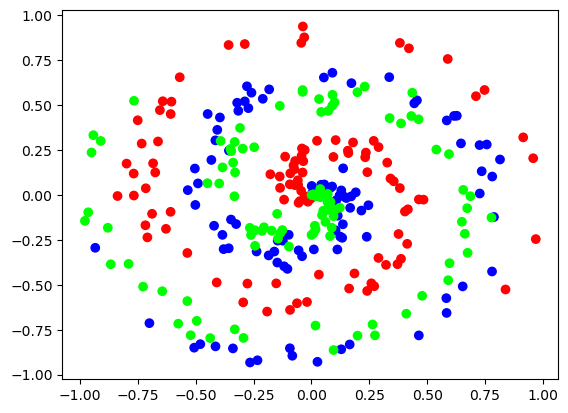

In [6]:

# Create dataset
X, y = spiral_data(samples=100, classes=3)

plt.scatter(X[:,0], X[:,1], c=y, cmap = 'brg')
plt.show()
# print(X)
# print(y)

In [7]:
# Create Dense layer with 2 input features and 3 output values
dense1 = Layer_Dense(2, 3)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 3 input features (as we take output
# of previous layer here) and 3 output values
dense2 = Layer_Dense(3, 3)

# Create Softmax activation (to be used with Dense layer):
activation2 = Activation_Softmax()

# Create loss function
loss_function = Loss_CategoricalCrossentropy()

# Perform a forward pass of our training data through this layer
dense1.forward(X)

# Perform a forward pass through activation function
# it takes the output of first dense layer here
activation1.forward(dense1.output)


# Perform a forward pass through second Dense layer
# it takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)

# Perform a forward pass through activation function
# it takes the output of second dense layer here
activation2.forward(dense2.output)

# Let's see output of the first few samples:
print(activation2.output[:10])

# Perform a forward pass through loss function
# it takes the output of second dense layer here and returns loss
loss = loss_function.calculate(activation2.output, y)

# Print loss value
print('loss:', loss)

[[0.33333334 0.33333334 0.33333334]
 [0.33333316 0.3333332  0.33333364]
 [0.33333287 0.3333329  0.33333418]
 [0.3333326  0.33333263 0.33333477]
 [0.33333233 0.3333324  0.33333528]
 [0.33333284 0.33333287 0.3333343 ]
 [0.33333182 0.3333319  0.33333626]
 [0.33333182 0.3333319  0.33333623]
 [0.3333315  0.3333316  0.33333692]
 [0.33333105 0.3333312  0.33333772]]
loss: 1.0986104


In [8]:
# Accuracy is easier to interpret

predictions = activation2.output
predictions = np.argmax(predictions, axis=1)
accuracy = np.mean(predictions==y)
print('accuracy:', accuracy)

accuracy: 0.34


## **Calculus Recap**

In this section, we revisit essential concepts from calculus that form the foundation of gradient-based optimization techniques in neural networks. Specifically, we will cover **partial derivatives**, the **gradient**, and the **chain rule**. These tools are crucial for understanding and implementing the backpropagation algorithm, which enables neural networks to learn from data.

---

### **Partial Derivatives**

Partial derivatives are a generalization of ordinary derivatives to functions of multiple variables. When a function $f(x_1, x_2, \dots, x_n)$ depends on several variables, the partial derivative with respect to one of these variables measures how $f$ changes when that specific variable changes, while all other variables remain constant.

The partial derivative of $f$ with respect to $x_i$ is denoted as:

$$
\frac{\partial f}{\partial x_i}
$$

For example, if $f(x, y) = x^2 + 3xy + y^2$, the partial derivatives are:

$$
\frac{\partial f}{\partial x} = 2x + 3y, \quad \frac{\partial f}{\partial y} = 3x + 2y
$$

---

### **The Gradient**

The gradient of a scalar function $f(x_1, x_2, \dots, x_n)$ is a vector that points in the direction of the steepest ascent of $f$. It is composed of all the partial derivatives of $f$ with respect to its variables:

$$
\nabla f = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\frac{\partial f}{\partial x_2} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}
$$

For the same example $f(x, y) = x^2 + 3xy + y^2$, the gradient is:

$$
\nabla f = \begin{bmatrix}
\frac{\partial f}{\partial x} \\
\frac{\partial f}{\partial y}
\end{bmatrix} =
\begin{bmatrix}
2x + 3y \\
3x + 2y
\end{bmatrix}
$$

The gradient is a key concept in gradient descent, as it guides us in updating parameters to minimize a given loss function.

---

### **The Chain Rule**

The chain rule allows us to compute the derivative of a composite function. If $z$ depends on $y$, and $y$ depends on $x$, then the rate of change of $z$ with respect to $x$ can be found using:

$$
\frac{dz}{dx} = \frac{dz}{dy} \cdot \frac{dy}{dx}
$$

In the context of partial derivatives, if $f$ is a function of $u_1, u_2, \dots, u_m$, and each $u_i$ is a function of $x_1, x_2, \dots, x_n$, the chain rule is expressed as:

$$
\frac{\partial f}{\partial x_j} = \sum_{i=1}^m \frac{\partial f}{\partial u_i} \cdot \frac{\partial u_i}{\partial x_j}
$$

The chain rule is particularly important in neural networks for calculating gradients through layers of non-linear transformations.

---

By combining these concepts—partial derivatives, gradients, and the chain rule—we can derive the mathematical framework for **gradient descent**, the algorithm that enables neural networks to optimize their parameters and learn from data.


# **Lecture 5: Backpropagation**

Now that we understand how to measure the impact of variables on a function’s output, we can begin writing code to calculate partial derivatives and analyze their role in minimizing the model’s loss. To simplify the process, we’ll start by backpropagating the ReLU function for a single neuron, treating it as a demonstration exercise before applying it to a full neural network. The goal is to use the chain rule with derivatives and partial derivatives to understand how each variable affects the ReLU output, laying the groundwork for minimizing the overall loss later.

In [9]:
# Consider a simple neuron with 2 inputs

x = [1.0, -2.0]
w = [3.0, -1.0]
b = 1

for i in range(len(x)):
    print(f"Output {i+1}: {x[i]*w[i]}")

Output 1: 3.0
Output 2: 2.0


In [10]:
# Completting the forward pass

total = 0
for i in range(len(x)):
    total += x[i]*w[i]
total += b
print(total)

6.0


In [11]:
# ReLU activation function
output = max(total,0)
print(output)

6.0


<img src="NN.png" alt="Image Alt Text" width="800"/>


### Chain Rule

The chain rule is used to differentiate composite functions. If you have a function \( y = f(g(x)) \), the derivative is given by:

$$
\frac{d}{dx} f(g(x)) = f'(g(x)) \cdot g'(x)
$$

In our example:

$$
\begin{aligned}
f(x) &= \text{ReLU}(x), \\
g(x) &= x_1 \cdot w_1 + x_1 \cdot w_2 + x_1 \cdot w_3 + b, \\
\implies f(g(x)) &= \text{ReLU}(x_1 \cdot w_1 + x_1 \cdot w_2 + x_1 \cdot w_3 + b)
\end{aligned}
$$

The derivative of ReLU is given by:

$$
\begin{aligned}
f(x) &= \text{max}(x, 0), \\
\implies \frac{d}{dx}f(x) &= 1 \quad (x > 0), \\
&= 0 \quad (x \leq 0)
\end{aligned}
$$







In [12]:
# In python

relu_d = (1. if total > 0 else 0.)
print(total)

6.0


<img src="ReLUd.png" alt="Image Alt Text" width="800"/>

### Chain Rule

The chain rule is used to differentiate composite functions. If you have a function \( y = f(g(x)) \), the derivative is given by:

$$
\frac{d}{dx} f(g(x)) = f'(g(x)) \cdot g'(x)
$$

In our example:

$$
\begin{aligned}
f(x) &= \text{ReLU}(x), \\
g(x) &= x_1 \cdot w_1 + x_1 \cdot w_2 + x_1 \cdot w_3 + b, \\
\implies f(g(x)) &= \text{ReLU}(x_1 \cdot w_1 + x_1 \cdot w_2 + x_1 \cdot w_3 + b)
\end{aligned}
$$

The derivative of ReLU is given by:

$$
\begin{aligned}
f(x) &= \text{max}(x, 0), \\
\implies \frac{d}{dx}f(x) &= 1 \quad (x > 0), \\
&= 0 \quad (x \leq 0)
\end{aligned}
$$

### Gradient Descent

In optimization, gradient descent is a method used to minimize a function iteratively. Given a loss function $ L(w) $, the weight updates are given by:

$$
w = w - \eta \cdot \nabla_w L(w)
$$

where:
- $ w $ is the weight,
- $ \eta $ is the learning rate,
- $ \nabla_w L(w) $ is the gradient of the loss function with respect to the weights.

For our example, the gradient of the loss with respect to the weights can be computed using the chain rule:

$$
\nabla_w L(w) = \frac{\partial L}{\partial f(g(x))} \cdot \frac{\partial f(g(x))}{\partial g(x)} \cdot \frac{\partial g(x)}{\partial w}
$$

Using the chain rule, we propagate the gradients backward from the output to the weights. In this case, the derivative of $ f(g(x)) $ with respect to $ g(x) $ depends on the ReLU function, and the derivative of $ g(x) $ with respect to $ w_1 $ is simply $ x_1 $.

Thus, the weight update rule becomes:

$$
w_1 = w_1 - \eta \cdot \frac{\partial L}{\partial f(g(x))} \cdot \frac{\partial f(g(x))}{\partial g(x)} \cdot x_1
$$

### Gradient Descent for Each Weight Component

Now, let's break down how the gradient descent works for each individual weight component $( w_1 ,  w_2 ,  w_3 )$.

- **For \( w_1 \):**
  The partial derivative of $ g(x) $ with respect to $ w_1 $ is $ x_1 $. So, the weight update rule for $ w_1 $ becomes:

  $$
  w_1 = w_1 - \eta \cdot \frac{\partial L}{\partial f(g(x))} \cdot \frac{\partial f(g(x))}{\partial g(x)} \cdot x_1
  $$

- **For \( w_2 \):**
  Similarly, the partial derivative of \( g(x) \) with respect to \( w_2 \) is \( x_2 \). Thus, the weight update rule for \( w_2 \) is:

  $$
  w_2 = w_2 - \eta \cdot \frac{\partial L}{\partial f(g(x))} \cdot \frac{\partial f(g(x))}{\partial g(x)} \cdot x_2
  $$

- **For \( w_3 \):**
  The partial derivative of \( g(x) \) with respect to \( w_3 \) is \( x_3 \). So the weight update rule for \( w_3 \) is:

  $$
  w_3 = w_3 - \eta \cdot \frac{\partial L}{\partial f(g(x))} \cdot \frac{\partial f(g(x))}{\partial g(x)} \cdot x_3
  $$

### Summary

The gradient descent updates each weight $ w_1 $, $ w_2 $, and $ w_3 $. The updates depend on the gradient of the loss with respect to the output of the ReLU function, which is propagated through the chain rule. The learning rate $ \eta $ controls how large the weight updates are in each iteration.



In [13]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler # Deal with categorical data
from sklearn.model_selection import train_test_split

import tensorflow as tf
import torch
import torch.nn as nn # Neural Networks
import torch.nn.functional as F
import torch.optim as optim # Optimizers
from torch.utils.data import Dataset, DataLoader

In [14]:
pd.set_option('display.max_columns', None) # Visualize all columns

In [15]:
# We will stary by loading our kaggle data set

data_path = "./kaggle/train.csv" # This is the path where the data is located
data = pd.read_csv(data_path)
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,

In [16]:
# data.info()

In [17]:
data = data.drop('Id', axis=1)

In [18]:
def onehot_encode(data, column, prefix=None):
    """
    One-hot encodes a specified column in the dataset.
    
    Parameters:
        data (pd.DataFrame): The input dataframe.
        column (str): The name of the column to encode.
        prefix (str, optional): The prefix for one-hot encoded column names. Defaults to the column name.
    
    Returns:
        pd.DataFrame: A dataframe with the specified column one-hot encoded.
    """
    data = data.copy()
    if prefix is None:
        prefix = column
    dummies = pd.get_dummies(data[column], prefix=prefix)
    data = pd.concat([data, dummies], axis=1)
    data = data.drop(column, axis=1)
    return data

In [19]:
# Identify non-numeric columns
non_numeric_cols = data.select_dtypes(include=['object']).columns

# Apply one-hot encoding to all non-numeric columns
for col in non_numeric_cols:
    data = onehot_encode(data, col, None)

# Display the updated datasetdata.head())
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_T

In [20]:
boolean_columns = data.select_dtypes(include=['bool']).columns
data[boolean_columns] = data[boolean_columns].astype(int)
data = data.dropna()
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_T

In [21]:
y = data['SalePrice']
X = data.drop('SalePrice', axis=1).copy()

In [22]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 1)

# TensorFlow Implementation

In [24]:
X_train.shape

(784, 287)

In [25]:
inputs = tf.keras.Input(shape = (287,))
hidden = tf.keras.layers.Dense(512, activation='relu')(inputs)
hidden = tf.keras.layers.Dense(256, activation='relu')(hidden)
outputs = tf.keras.layers.Dense(1, activation='linear')(hidden)

tf_model = tf.keras.Model(inputs, outputs)

tf_model.compile(
    optimizer='adam',
    loss = 'mse')

history = tf_model.fit(
    X_train,
    y_train,
    validation_split=0.12,
    batch_size=32,
    epochs=500
)

Epoch 1/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46000398336.0000 - val_loss: 37576392704.0000
Epoch 2/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41059237888.0000 - val_loss: 37493264384.0000
Epoch 3/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 41976123392.0000 - val_loss: 37229981696.0000
Epoch 4/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43057221632.0000 - val_loss: 36625412096.0000
Epoch 5/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 41334124544.0000 - val_loss: 35493154816.0000
Epoch 6/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42683891712.0000 - val_loss: 33644861440.0000
Epoch 7/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35226824704.0000 - val_loss: 31099342848.0000
Epoch 8/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33180524544.0000 - val_loss: 27786446848.0000
Epoch 9/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28076095488.0000 - val_loss: 24159924224.0000
Epoch 10/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - l

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 859887808.0000 - val_loss: 4147769600.0000
Epoch 61/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 908545984.0000 - val_loss: 4129904896.0000
Epoch 62/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 797915648.0000 - val_loss: 4101491968.0000
Epoch 63/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 803851456.0000 - val_loss: 4074379264.0000
Epoch 64/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 845979072.0000 - val_loss: 4053976832.0000
Epoch 65/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 776960768.0000 - val_loss: 4033421824.0000
Epoch 66/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 808949504.0000 - val_loss: 4013221888.0000
Epoch 67/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 851445440.0000 - val_loss: 3998958848.0000
Epoch 68/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 756868672.0000 - val_loss: 3974004480.0000
Epoch 69/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 664800960.0000 - val_loss:

Epoch 120/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 531342208.0000 - val_loss: 3390561536.0000
Epoch 121/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 433532256.0000 - val_loss: 3387528192.0000
Epoch 122/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 438306976.0000 - val_loss: 3383140352.0000
Epoch 123/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 394250304.0000 - val_loss: 3386684928.0000
Epoch 124/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 439155008.0000 - val_loss: 3363894528.0000
Epoch 125/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 477306400.0000 - val_loss: 3372584960.0000
Epoch 126/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 460390176.0000 - val_loss: 3375645184.0000
Epoch 127/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 460357696.0000 - val_loss: 3349487360.0000
Epoch 128/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 542167552.0000 - val_loss: 3352384512.0000
Epoch 129/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 404

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 282053376.0000 - val_loss: 3137325568.0000
Epoch 180/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 325804256.0000 - val_loss: 3130732032.0000
Epoch 181/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 366580544.0000 - val_loss: 3139793664.0000
Epoch 182/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 293242016.0000 - val_loss: 3134893824.0000
Epoch 183/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 277353728.0000 - val_loss: 3132675328.0000
Epoch 184/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 267463312.0000 - val_loss: 3123463680.0000
Epoch 185/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 314013504.0000 - val_loss: 3126614272.0000
Epoch 186/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 284227008.0000 - val_loss: 3122594560.0000
Epoch 187/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 324741152.0000 - val_loss: 3119427840.0000
Epoch 188/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 291505504.0000 - 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 267855968.0000 - val_loss: 2979174144.0000
Epoch 239/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 187493248.0000 - val_loss: 2986451456.0000
Epoch 240/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 186007456.0000 - val_loss: 2974638336.0000
Epoch 241/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 261132992.0000 - val_loss: 2987522816.0000
Epoch 242/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 197189504.0000 - val_loss: 2971887872.0000
Epoch 243/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 229736864.0000 - val_loss: 2974243840.0000
Epoch 244/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 207600960.0000 - val_loss: 2970831616.0000
Epoch 245/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 188207296.0000 - val_loss: 2966167296.0000
Epoch 246/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 179124592.0000 - val_loss: 2969825280.0000
Epoch 247/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 197630144.0000 - 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 160967136.0000 - val_loss: 2872131328.0000
Epoch 298/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 168913360.0000 - val_loss: 2867936512.0000
Epoch 299/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170338544.0000 - val_loss: 2865118720.0000
Epoch 300/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157854800.0000 - val_loss: 2870891520.0000
Epoch 301/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 172842064.0000 - val_loss: 2848154624.0000
Epoch 302/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 181541568.0000 - val_loss: 2855848704.0000
Epoch 303/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166771728.0000 - val_loss: 2863097344.0000
Epoch 304/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150429312.0000 - val_loss: 2855841536.0000
Epoch 305/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150263408.0000 - val_loss: 2846114048.0000
Epoch 306/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 216518928.0000 - 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158936592.0000 - val_loss: 2767914240.0000
Epoch 357/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133342456.0000 - val_loss: 2749282048.0000
Epoch 358/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127102072.0000 - val_loss: 2754095104.0000
Epoch 359/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129614208.0000 - val_loss: 2755875072.0000
Epoch 360/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136223616.0000 - val_loss: 2748568064.0000
Epoch 361/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 97166720.0000 - val_loss: 2748081152.0000
Epoch 362/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124236960.0000 - val_loss: 2749326848.0000
Epoch 363/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119906176.0000 - val_loss: 2744049664.0000
Epoch 364/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143704848.0000 - val_loss: 2751444224.0000
Epoch 365/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145562064.0000 - v

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85715816.0000 - val_loss: 2659195648.0000
Epoch 416/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103966560.0000 - val_loss: 2664239872.0000
Epoch 417/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85492704.0000 - val_loss: 2654143744.0000
Epoch 418/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137597408.0000 - val_loss: 2658839552.0000
Epoch 419/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89444824.0000 - val_loss: 2644930816.0000
Epoch 420/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100973376.0000 - val_loss: 2656734208.0000
Epoch 421/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70173552.0000 - val_loss: 2651337984.0000
Epoch 422/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122669992.0000 - val_loss: 2650147840.0000
Epoch 423/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84987336.0000 - val_loss: 2648558080.0000
Epoch 424/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 91720896.0000 - val_lo

Epoch 475/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 66068144.0000 - val_loss: 2574693632.0000
Epoch 476/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52758976.0000 - val_loss: 2573930752.0000
Epoch 477/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 66176676.0000 - val_loss: 2571922432.0000
Epoch 478/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 80833896.0000 - val_loss: 2569025024.0000
Epoch 479/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 74096384.0000 - val_loss: 2567428608.0000
Epoch 480/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46174384.0000 - val_loss: 2569595648.0000
Epoch 481/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57946800.0000 - val_loss: 2563916544.0000
Epoch 482/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50659812.0000 - val_loss: 2563077888.0000
Epoch 483/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50196692.0000 - val_loss: 2563383808.0000
Epoch 484/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55948360.000

In [26]:
tf_rmse = np.sqrt(tf_model.evaluate(X_test, y_test))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 2181367552.0000


## Pytorch Implementation

In [28]:
class PricePrediction(nn.Module):
    def __init__(self):
        super(PricePrediction, self).__init__()
        self.layer1 = nn.Linear(287, 512)
        self.layer2 = nn.Linear(512, 256)
        self.output = nn.Linear(256, 1)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output(x)
        return x

In [31]:
model = PricePrediction()

# Visualize all the weights
# list(model.parameters())

# for i in range(len(list(model.parameters()))):
    # print(list(model.parameters())[i].shape)

torch.Size([512, 287])
torch.Size([512])
torch.Size([256, 512])
torch.Size([256])
torch.Size([1, 256])
torch.Size([1])


In [32]:
# Conver data to torch tensors

t_X_train = torch.tensor(X_train).type(torch.float32)
t_y_train = torch.tensor(np.array(y_train)).type(torch.float32)

t_X_test = torch.tensor(X_test).type(torch.float32)
t_y_test = torch.tensor(np.array(y_test)).type(torch.float32)

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Use the Adam Optimizer
criterion = nn.MSELoss() # Use MSE loss (one taught in class)

In [41]:
# Training

for x, target in zip(t_X_train, t_y_train):
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

/Users/manu13/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [43]:
total_loss = 0

# Testing Model with validation data

for x, target in zip(t_X_test, t_y_test):
    output = model(x)
    loss = criterion(output, target)
    total_loss += loss
    
avg_loss = total_loss / len(t_X_test)

In [44]:
# Return RMSE to compare performance with TF

torch_rmse = torch.sqrt(avg_loss).detach().numpy()

In [40]:
print(np.sqrt(7206027915.6364))

84888.32614462603


In [46]:
print("TensorFlow RMSE:", tf_rmse)
print("PyTorch RMSE:", torch_rmse)

# Pytorch performed better

TensorFlow RMSE: 46828.99341220138
PyTorch RMSE: 41934.223


### Question 1

Now it's your turn to implement a neural network! Using the provided **NNFS** dataset, create a simple neural network in both **PyTorch** and **TensorFlow** to perform a classification task. For this task, make sure to:

- Use **BCELoss** (Binary Cross-Entropy Loss) as your loss function.
- Apply the **Softmax** activation function in the output layer to normalize the predicted values into probabilities.

You can refer to the documentation for both libraries for more details on how to implement this. Try to compare the results between the two frameworks and see how they perform!

---

### Question 2

Can you implement a simple neural network from scratch that takes two values from the dataset as inputs? You’ll need to apply the backpropagation algorithm we’ve covered in class to train the network. This implementation should be very similar to the one discussed in **Lecture 3**, with the key difference being that **Lecture 3** uses a network without the ReLU activation.

Please refer to the **PDF** and **Lecture 3** for guidance. If you followed the steps there, this should be straightforward! You’ll need to ensure you're applying the right forward pass, loss function, and backpropagation steps as we learned.

---

Good luck! 😄
